

# Fourier Analysis in NT and Markets

In this warmup notebook, we compare the application of Fourier series analysis in Number Theory and market data.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log
import scipy.stats as stats
import yfinance as yf
import datetime as dt

In [2]:
def von_Mangoldt(N):
    #Return an np.arrey Lambda[0,1,...,N], where Lambda is a simplified von mangoldt function, taking log value on primes. With the convention \Lambda(0)=0
    Lam=np.zeros(N, dtype=float)
    is_prime=np.ones(N+1, dtype=bool)

    for p in range(2, N):
        if not is_prime[p]:
            continue
        is_prime[p*p::p]=0
        Lam[p]=log(p)
    return Lam

By the Prime-Number Theorem, the sum of von Mangoldt up to N should be around N.

In [3]:
primo=9699690 #2*3*5*7*11*13*17*19

N=primo*1 #Chosing a multiple of primorial, to make the effect of small prime divisor of frequency denominator better visible.

Lambda=von_Mangoldt(N)
print("N:", N, "sum Lambda:", Lambda.sum())

N: 9699690 sum Lambda: 9696470.977783008


Calculate some basic stats, which are of course not very suitable for $\Lambda$, but useful for later comparison with SPY data.

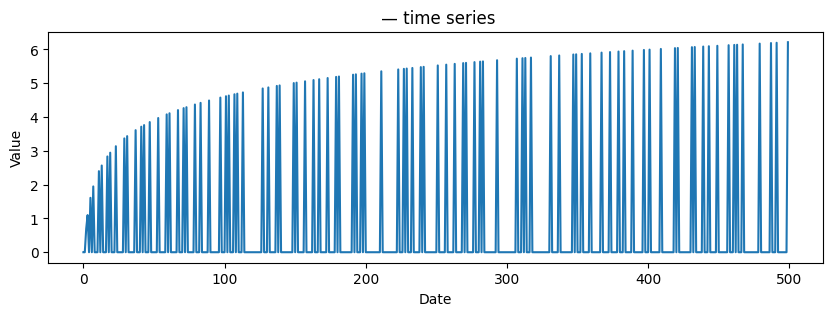

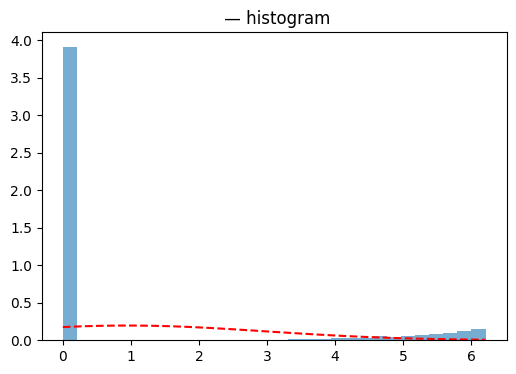

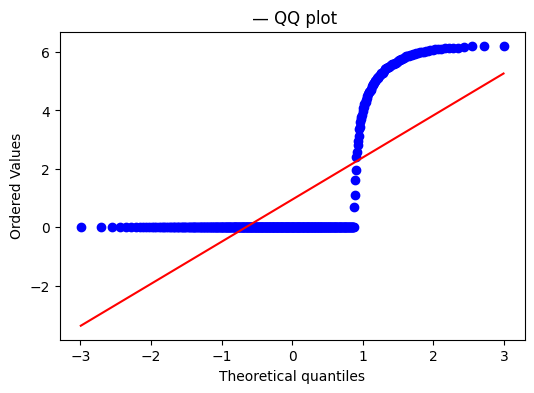

Mean is 0.9491088883093884 SD is 2.0274903431974143


In [4]:
def plot_column_distribution(x):

    # Time series (index on x-axis)
    plt.figure(figsize=(10,3))
    plt.plot(x)
    plt.title(f" — time series")
    plt.xlabel(f"Date")
    plt.ylabel("Value")
    plt.show()

    # Histogram
    plt.figure(figsize=(6,4))
    plt.hist(x, bins=30, density=True, alpha=0.6)
    mu, sigma = x.mean(), x.std(ddof=1)
    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, stats.norm.pdf(xs, mu, sigma), "r--")
    plt.title(f" — histogram")
    plt.show()

    # QQ plot
    plt.figure(figsize=(6,4))
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(f" — QQ plot")
    plt.show()

    print(f'Mean is {x.mean()}', f'SD is {x.std()}')

plot_column_distribution(Lambda[0:500])

We next calculate $\hat{\Lambda}(\alpha)=\sum_{n\leq N}\Lambda(n) e^{2\pi i \alpha n}$

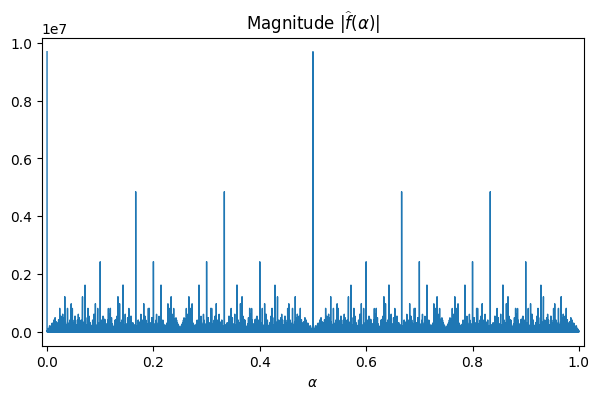

In [5]:
def hat(Array):
    #Simple fft that return alpha value and fourier transform. No padding or hann window.
    N=len(Array)
    alphas=np.arange(N)/N
    X=np.fft.fft(Array)
    return alphas, X

def plot_spectrum(f):
    alphas, X=hat(f)
    mag=np.abs(X)
    plt.figure(figsize=(7,4))
    plt.plot(alphas, mag, lw=1)
    plt.xlim(-0.01, 1.01)
    plt.xlabel(r'$\alpha$')
    plt.title(r'Magnitude $|\widehat{f}(\alpha)|$')
    plt.show()

plot_spectrum(Lambda)

We know that $|\hat{\Lambda}(\alpha)|$ should be of size $N/q$ if $\alpha$ is close to a rational number with denominator $q$. Let's extract this information numerically.

In [7]:

def large_spec(f, rel_size=0.01):
    alphas, X=hat(f)
    mag=np.abs(X)
    thresh = rel_size * float(mag.max())
    large= mag > thresh
    print(f'The maximum magnitude is {mag.max()}, there are {large.sum()} out of {alphas.shape[0]} large signals')
    padded=np.r_[0, large.view(np.int8), 0] #reinterpret Bool as int values, and add 0 at beginning and end
    diff= np.diff(padded)  #Differentiate to discover runs
    starts= np.where(diff == 1)[0]
    ends= np.where(diff == -1)[0]
    sel_indices = []
    for s, e in zip(starts, ends):
        # choose index of max magnitude inside cluster
        cluster_idx = np.arange(s, e)
        local_idx = cluster_idx[np.argmax(mag[cluster_idx])]
        sel_indices.append(int(local_idx))
    sel_indices = np.array(sel_indices, dtype=int)
    order = np.argsort(-np.abs(X[sel_indices]))
    sel_indices = sel_indices[order]
    return alphas[sel_indices],X[sel_indices]



Testing some values:

In [9]:
lsLambda=large_spec(Lambda)
print(lsLambda[0][:10])
print(lsLambda[1][:10])

The maximum magnitude is 9696470.977783008, there are 4538 out of 9699690 large signals
[0.         0.5        0.66666667 0.33333333 0.16666667 0.83333333
 0.8        0.2        0.7        0.3       ]
[ 9696470.97778301+0.00000000e+00j -9696469.59148864-9.37916411e-11j
 -4848233.84097307-2.59042928e+03j -4848233.84097307+2.59042928e+03j
  4848233.14782589+2.58922871e+03j  4848233.14782589-2.58922871e+03j
 -2426052.65135568+9.47633917e+02j -2426052.65135568-9.47633917e+02j
  2426051.52981998+9.46819073e+02j  2426051.52981998-9.46819073e+02j]


We extract next a physical space approximant that capture behaviours at large Fourier frequencies, via
$$\Lambda_{\approx}=\Lambda*K(n),$$
where
$$K(n)=\sum_{\alpha \in \mathcal{S}} e(\alpha n)\frac{1_{|n|\leq L}}{2L+1}.$$

Since physical (time) space convolution requires $LN=cN^2$ ($c$ is scale below) steps, it is not feasible. Instead we use multiplication in frequency space and inverse Fourier, making use of the fact that FFT has time complexity $O(N\log N)$.

In [56]:
def fou_approx(f, rel_size=0.01, R=10, scale=0.1):
    #Inclusion of a scale means we carry information more than $1/N$ away from peaks. This is mathematically meaningful, since one can only show smallness of \hat{\Lambda} if we are sufficiently away from peaks.

    largalpha=large_spec(f, rel_size=rel_size)[0][:R]

    def _next_pow2(x):
        x = int(x)
        if x <= 1:
            return 1
        return 1 << ((x - 1).bit_length())

    N = f.shape[0]
    Y = min(int(R), len(largalpha))

    ZN = int(np.floor(scale * N))
    if ZN < 0:
        ZN = 0

    alphas = np.array(largalpha[:Y], dtype=float)  # selected alphas
    Klen = 2 * ZN + 1                              # kernel length (t = -ZN..ZN)

    if Y == 0 or Klen == 0:
        return np.zeros(N, dtype=float)


    t = np.arange(-ZN, ZN + 1)                     # length Klen
    K_time = np.exp(2j * np.pi * np.outer(alphas, t)).sum(axis=0).astype(np.complex128) #This creates the function K in time (physical) domain, by first creating a matrix of pairs and summing then.


    L = N + Klen - 1
    M = _next_pow2(L)                                #We create a power of 2 that contains the maximal time space length required for the linear convolution. Standard FFT should use binary splitting, so this is the best choice trading run time and precision.

    # use complex FFTs because K_time is complex
    A = np.fft.fft(f, n=M)
    B = np.fft.fft(K_time, n=M)
    conv_full = np.fft.ifft(A * B, n=M).real[:L]   #  convolution result

    # 'same' slice: align t=0 with index ZN -> take conv_full[ZN:ZN+N]
    start = ZN
    end = ZN + N
    conv_same = conv_full[start:end]

    # counts (averaging divisor): convolution of ones(N) with ones(Klen) via FFT. Thus normalising by unit interval convolution
    ones_N = np.ones(N, dtype=float)
    ones_K = np.ones(Klen, dtype=float)
    C = np.fft.ifft(np.fft.fft(ones_N, n=M) * np.fft.fft(ones_K, n=M), n=M).real[:L]
    counts = C[start:end]
    counts[counts == 0] = 1.0

    fapprox = conv_same / counts
    return fapprox

Lapprox = fou_approx(Lambda, R=20)


The maximum magnitude is 9696470.977783008, there are 4538 out of 9699690 large signals


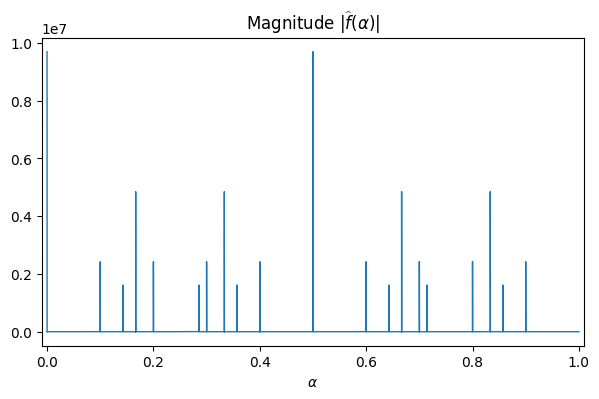

In [13]:
plot_spectrum(Lapprox) #We should see the peaks from before.

Having confirmed that the spectral lines match the peaks, we gather some statistics.

In [14]:
def fit_stats(F, Fapprox):
    F = np.asarray(F, float)
    Fapprox = np.asarray(Fapprox, float)
    Fres=F-Fapprox

    L2=np.linalg.norm(Fres)
    rel_L2=L2/np.linalg.norm(F)

    Fc=F-F.mean()
    R2=1.0-(L2**2)/(np.linalg.norm(Fc)**2)

    resabs=np.abs(Fres)

    out = {
        "rel_L2": rel_L2,
        "R2_explained_var": R2,
        "RMSE": np.sqrt(np.mean(Fres*Fres)),
        "MAE": np.mean(resabs),
        "MedAE": np.median(resabs),
        "Q95_AE": np.quantile(resabs, 0.95),
        "Linf": np.max(resabs),
    }
    df = pd.DataFrame(out, index=["value"]).T
    return df

print(fit_stats(Lambda, Lapprox))



                      value
rel_L2             0.870080
R2_explained_var   0.189244
RMSE               3.379111
MAE                1.770452
MedAE              0.332872
Q95_AE            10.873033
Linf              12.944322


The most interesting stat is here the $19$% explained variance with only few frequencies.
## SPY Data
Let's see what happens if we apply the same methodology to SPY data next.

In [28]:
#Importing the YF SPY minute data in the last week
end = dt.datetime.now()
start = end - dt.timedelta(days=8)
data = yf.download(
    tickers="SPY",
    start=start,
    end=end,
    interval="1m",
    progress=False,
    auto_adjust=True
)

In [29]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Datetime,,,,,
2025-12-26 14:30:00+00:00,690.390015,690.969971,690.390015,690.640015,1112996
2025-12-26 14:31:00+00:00,690.429993,690.599976,690.270020,690.400024,352444
2025-12-26 14:32:00+00:00,690.729919,690.739990,690.400024,690.440002,274951
2025-12-26 14:33:00+00:00,691.045105,691.054993,690.520020,690.705017,166769
2025-12-26 14:34:00+00:00,690.945007,691.090027,690.940002,691.039978,150853


In [30]:
closeseq=data['Close'].to_numpy().ravel()
closediff=np.diff(np.log(closeseq)) #Differences of logarithmic returns
closediff=closediff-closediff.mean() #Possible mean subtraction.
volseq=data['Volume'].to_numpy().ravel()
volseq=volseq-volseq.mean() #Necessary, because the 0 peak is else overwhelming.

print(closediff)
print(volseq)


[ 6.58980987e-05  4.42304758e-04  4.64197200e-04 ... -2.41153476e-04
 -2.85142165e-04 -5.49084590e-04]
[ 989049.10641026  228497.10641026  151004.10641026 ...  676025.10641026
 1660173.10641026 2081572.10641026]


[ 6.58980987e-05  4.42304758e-04  4.64197200e-04 -1.36866827e-04
  4.27588516e-04  1.30985873e-04 -3.81961827e-04  2.82196430e-04
  1.23745405e-04 -2.09654976e-05  1.67079992e-04  7.99333606e-06
  7.99333606e-06  2.10478806e-04  2.24676233e-05]


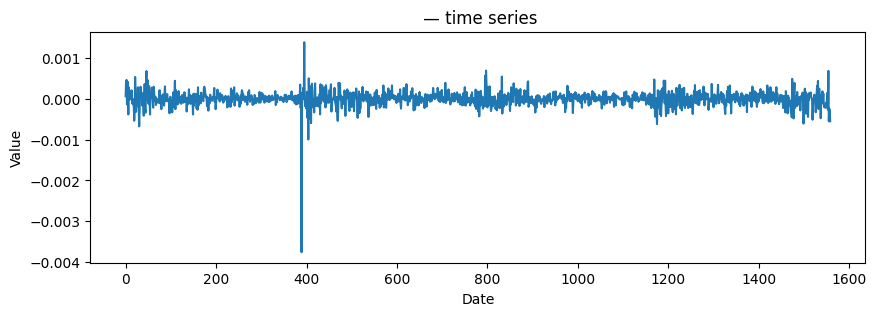

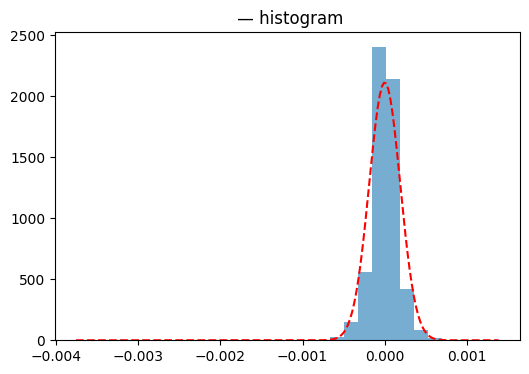

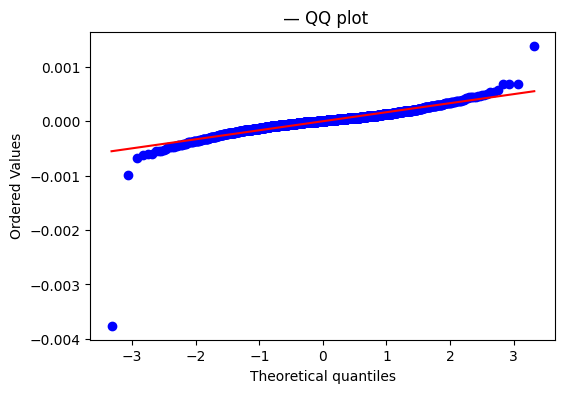

Mean is 8.067187428371937e-21 SD is 0.00018870966854028974


In [66]:
print(closediff[:15])
#plot_column_distribution(volseq)
plot_column_distribution(closediff)

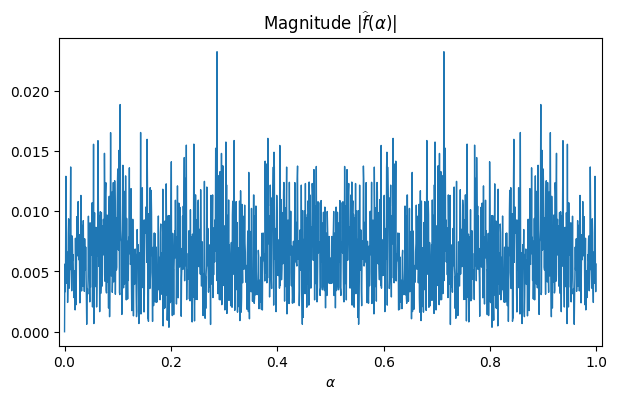

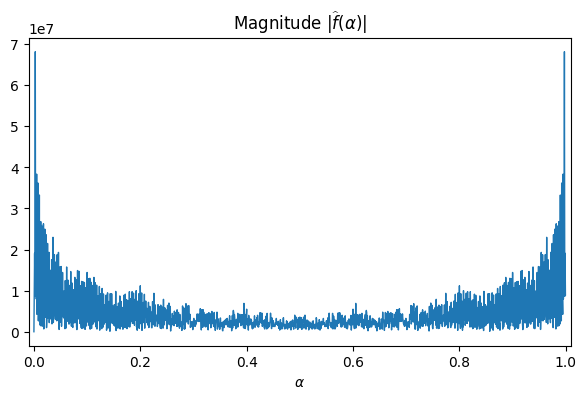

In [31]:
plot_spectrum(closediff)
plot_spectrum(volseq)

Next define set of large spectrum. Note that the pronounced noise, in particular in the difference sequence, requires us to fine tune the rel_size parameter so that not all peak areas are overlapping. For what we do below, we should choose it such that there are slightly over $30$ large signal frequencies.

In [35]:
large_spec(closediff, rel_size=0.6) #Call function to determine good rel_size choice
#large_spec(volseq, rel_size=0.25)


The maximum magnitude is 0.023235143964810096, there are 42 out of 1559 large signals


(array([0.28672226, 0.71327774, 0.8954458 , 0.1045542 , 0.14304041,
        0.85695959, 0.08659397, 0.91340603, 0.38229634, 0.61770366,
        0.15522771, 0.84477229, 0.6812059 , 0.3187941 , 0.06286081,
        0.93713919, 0.69660038, 0.30339962, 0.75689545, 0.24310455,
        0.94547787, 0.05452213, 0.77100706, 0.22899294, 0.59525337,
        0.40474663, 0.71584349, 0.28415651, 0.10198845, 0.89801155,
        0.39384221, 0.60615779, 0.07504811, 0.92495189, 0.70493906,
        0.29506094, 0.77485568, 0.22514432, 0.62283515, 0.37716485,
        0.79923028, 0.20076972]),
 array([ 0.01874982-0.01372284j,  0.01874982+0.01372284j,
         0.00048038+0.01884622j,  0.00048038-0.01884622j,
         0.01652519-0.00043932j,  0.01652519+0.00043932j,
         0.00852344-0.01415178j,  0.00852344+0.01415178j,
         0.00997605-0.0125661j ,  0.00997605+0.0125661j ,
         0.0092858 -0.01298799j,  0.0092858 +0.01298799j,
        -0.01505017+0.00502328j, -0.01505017-0.00502328j,
         0.01283

In [57]:
testR=[1,5,10,20,30]

for r in testR:
    closediffapprox =  fou_approx(closediff, rel_size=0.6, R=r, scale=0.1)
    print(f'For R={r}')
    print(fit_stats(closediff, closediffapprox))

The maximum magnitude is 0.023235143964810096, there are 42 out of 1559 large signals
For R=1
                     value
rel_L2            0.992365
R2_explained_var  0.015211
RMSE              0.000187
MAE               0.000116
MedAE             0.000080
Q95_AE            0.000338
Linf              0.003738
The maximum magnitude is 0.023235143964810096, there are 42 out of 1559 large signals
For R=5
                     value
rel_L2            0.978406
R2_explained_var  0.042722
RMSE              0.000185
MAE               0.000117
MedAE             0.000083
Q95_AE            0.000327
Linf              0.003665
The maximum magnitude is 0.023235143964810096, there are 42 out of 1559 large signals
For R=10
                     value
rel_L2            0.963448
R2_explained_var  0.071769
RMSE              0.000182
MAE               0.000117
MedAE             0.000085
Q95_AE            0.000326
Linf              0.003563
The maximum magnitude is 0.023235143964810096, there are 42 out of 15

In [55]:
for r in testR:
    Volapprox = fou_approx(volseq, rel_size=0.25, R=r, scale=0.1)
    print(f'For R={r}')
    print(fit_stats(volseq, Volapprox))

The maximum magnitude is 68140139.27347398, there are 36 out of 1560 large signals
[0.0025641]
For R=1
                         value
rel_L2            9.265601e-01
R2_explained_var  1.414863e-01
RMSE              1.454296e+05
MAE               6.602960e+04
MedAE             4.652389e+04
Q95_AE            1.415934e+05
Linf              1.987024e+06
The maximum magnitude is 68140139.27347398, there are 36 out of 1560 large signals
[0.0025641  0.9974359  0.99487179 0.00512821 0.00769231]
For R=5
                         value
rel_L2            8.515243e-01
R2_explained_var  2.749064e-01
RMSE              1.336523e+05
MAE               6.595188e+04
MedAE             3.896143e+04
Q95_AE            1.776269e+05
Linf              1.706129e+06
The maximum magnitude is 68140139.27347398, there are 36 out of 1560 large signals
[0.0025641  0.9974359  0.99487179 0.00512821 0.00769231 0.99230769
 0.01025641 0.98974359 0.01282051 0.98717949]
For R=10
                         value
rel_L2           

Let's compare those values against random surrogate models:
1. i.i.d bootstrap
2. gaussian
3. phase randomised
4. block bootstrap


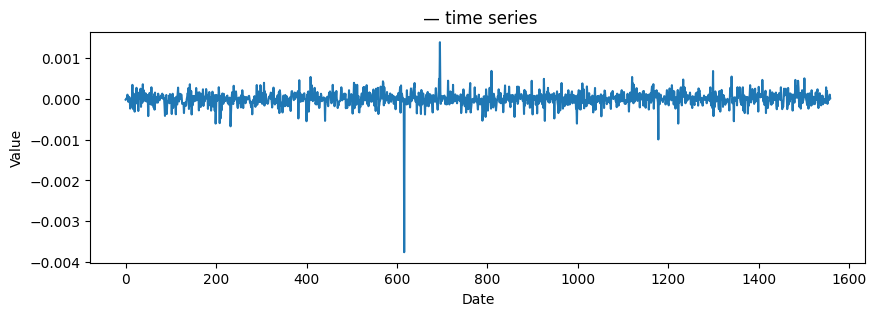

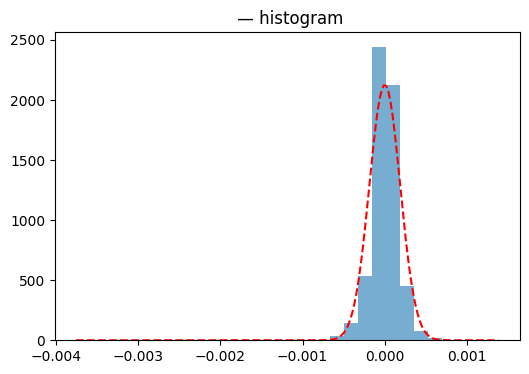

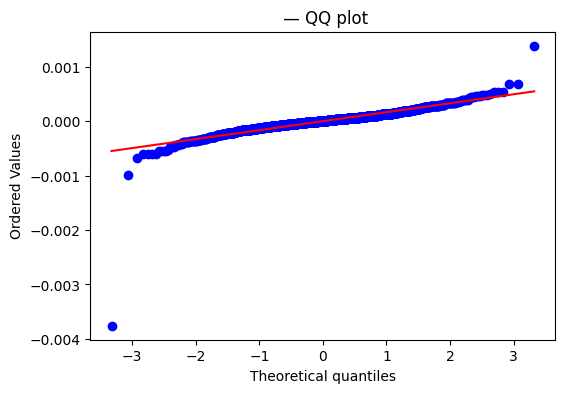

Mean is 8.852572381612914e-07 SD is 0.00018756468525132363


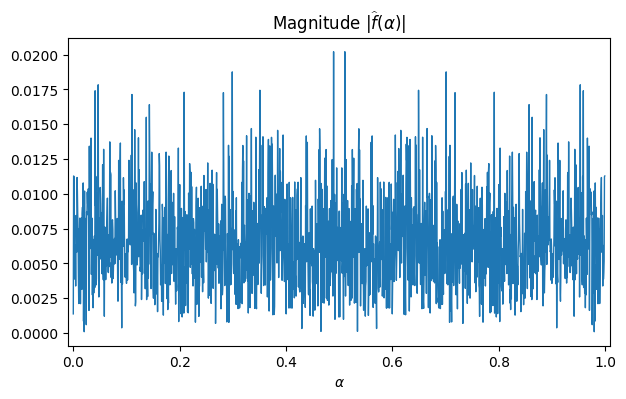

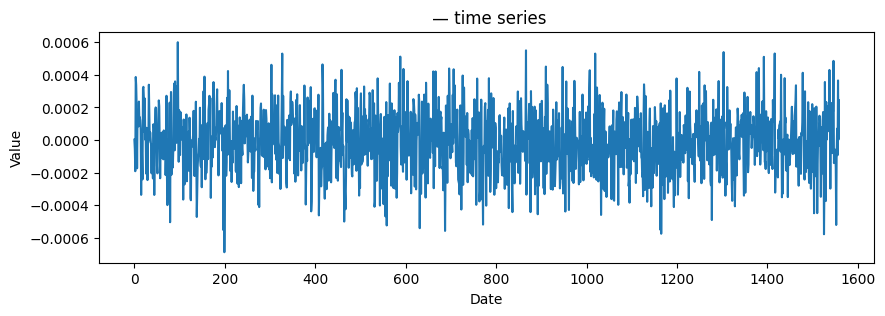

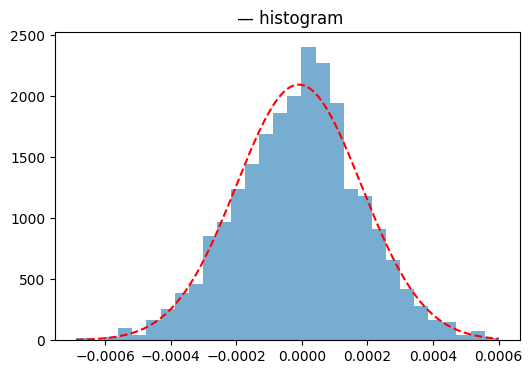

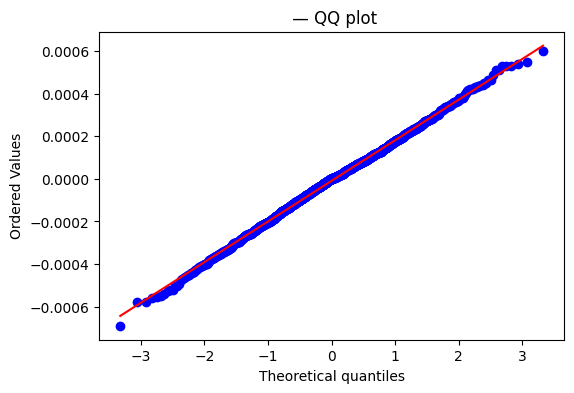

Mean is -9.14078411120829e-06 SD is 0.000190330153367866


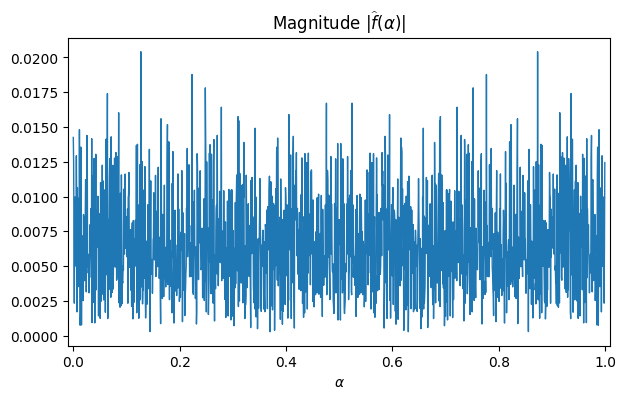

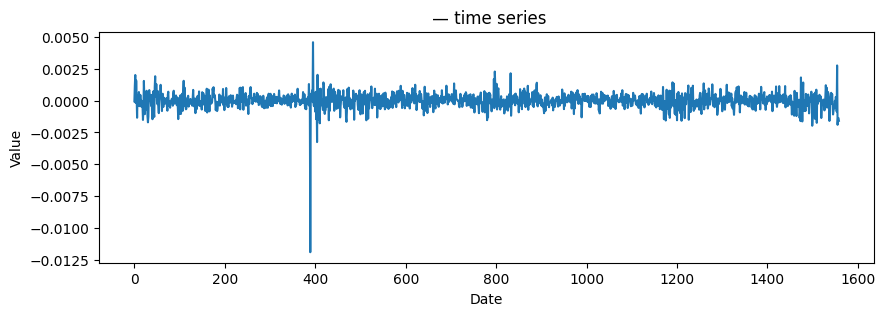

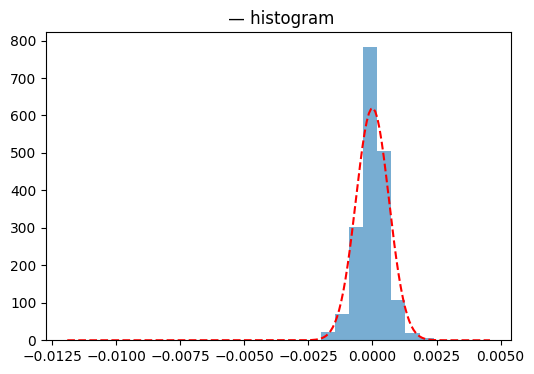

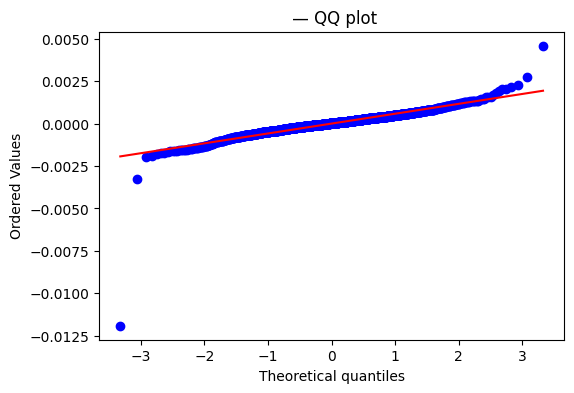

Mean is 0.0 SD is 0.0006436386717639005


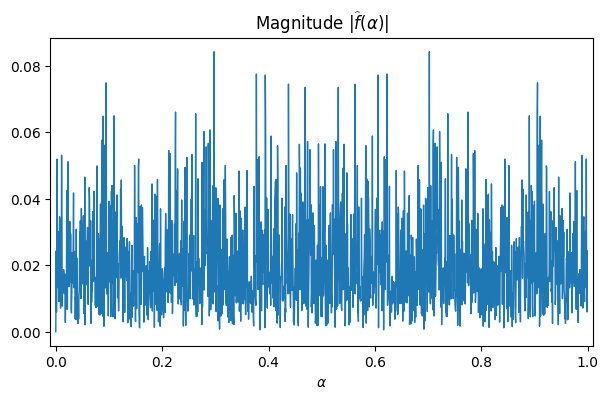

In [65]:
rng = np.random.default_rng(42)

def sur_bootstrap(y, rng):
    y = np.asarray(y, float)
    return rng.choice(y, size=y.size, replace=True)

def sur_gaussian(y, rng):
    y = np.asarray(y, float)
    return rng.normal(loc=y.mean(), scale=y.std(ddof=1), size=y.size)

def sur_phase(y, rng):
    y = np.asarray(y, float)
    n=y.size
    Y=np.fft.fft(y)

    phases= rng.uniform(0.0, 2*np.pi, size=Y.size)
    Y_new=phases*Y
    y_new=np.fft.ifft(Y_new)

    return np.real(y_new)

sur1diff=sur_bootstrap(closediff, rng)
sur2diff=sur_gaussian(closediff, rng)
sur3diff=sur_phase(closediff, rng)

surdiffs=[sur1diff, sur2diff, sur3diff]

for g in surdiffs:
    plot_column_distribution(g)
    plot_spectrum(g)


In [64]:
testR=[30]
for g in surdiffs:
    for r in testR:
        gapprox =  fou_approx(g, rel_size=0.6, R=r, scale=0.1)
        print(f'For R={r}')
        print(fit_stats(g, gapprox))

The maximum magnitude is 0.02021231625531403, there are 110 out of 1559 large signals
For R=30
                     value
rel_L2            0.906918
R2_explained_var  0.177481
RMSE              0.000170
MAE               0.000113
MedAE             0.000088
Q95_AE            0.000296
Linf              0.003240
The maximum magnitude is 0.020414834256448067, there are 131 out of 1559 large signals
For R=30
                     value
rel_L2            0.914255
R2_explained_var  0.162209
RMSE              0.000174
MAE               0.000139
MedAE             0.000116
Q95_AE            0.000339
Linf              0.000649
The maximum magnitude is 0.08420231273675713, there are 72 out of 1559 large signals
For R=30
                     value
rel_L2            0.881254
R2_explained_var  0.223392
RMSE              0.000567
MAE               0.000391
MedAE             0.000310
Q95_AE            0.001036
Linf              0.009785
